# Library

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import datetime

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar_time_series import time_series
from ursar import describe, deep_learning
%reload_ext autoreload

# Load data

In [3]:
df = pd.read_csv(r'E:\gitlab\dataset\time_series\PRSA_data_2010.1.1-2014.12.31.csv')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
describe.describe_data(df)

'table size 43824 x 13'

Dataframe has 13 columns.
There are 13 columns that have missing values.


,index,Data Type,Count,Missing,% missing,Low value,Q1,Mean,Median,Q3,Hi value,Mode,Stddev,Skewness,Skewness note,Uniques
0,No,int64,43824,0,0.00,1.00,10956.75,21912.50,21912.50,32868.25,43824.00,1.00,12651.04,0.00,Fairly Symmetric (Positive),43824
1,year,int64,43824,0,0.00,2010.00,2011.00,2012.00,2012.00,2013.00,2014.00,2012.00,1.41,0.00,Fairly Symmetric (Positive),5
2,month,int64,43824,0,0.00,1.00,4.00,6.52,7.00,10.00,12.00,1.00,3.45,-0.01,Fairly Symmetric (Negative),12
3,day,int64,43824,0,0.00,1.00,8.00,15.73,16.00,23.00,31.00,1.00,8.80,0.01,Fairly Symmetric (Positive),31
4,hour,int64,43824,0,0.00,0.00,5.75,11.50,11.50,17.25,23.00,0.00,6.92,0.00,Fairly Symmetric (Positive),24
5,pm2.5,float64,41757,2067,4.72,0.00,29.00,98.61,72.00,137.00,994.00,16.00,92.05,1.80,Highly Positively Skewed,581
6,DEWP,int64,43824,0,0.00,-40.00,-10.00,1.82,2.00,15.00,28.00,18.00,14.43,-0.15,Fairly Symmetric (Negative),69
7,TEMP,float64,43824,0,0.00,-19.00,2.00,12.45,14.00,23.00,42.00,24.00,12.20,-0.16,Fairly Symmetric (Negative),64
8,PRES,float64,43824,0,0.00,991.00,1008.00,1016.45,1016.00,1025.00,1046.00,1014.00,10.27,0.10,Fairly Symmetric (Positive),60
9,cbwd,object,43824,0,0.00,0,0,0,0,0,0,0,0,0,non-numeric,4


## create datetime feature

In [5]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda x: datetime.datetime(year=x['year'], month=x['month'], day=x['day'],
                                                                          hour=x['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

In [6]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


Text(0, 0.5, 'Air Pressure readings in hPa')

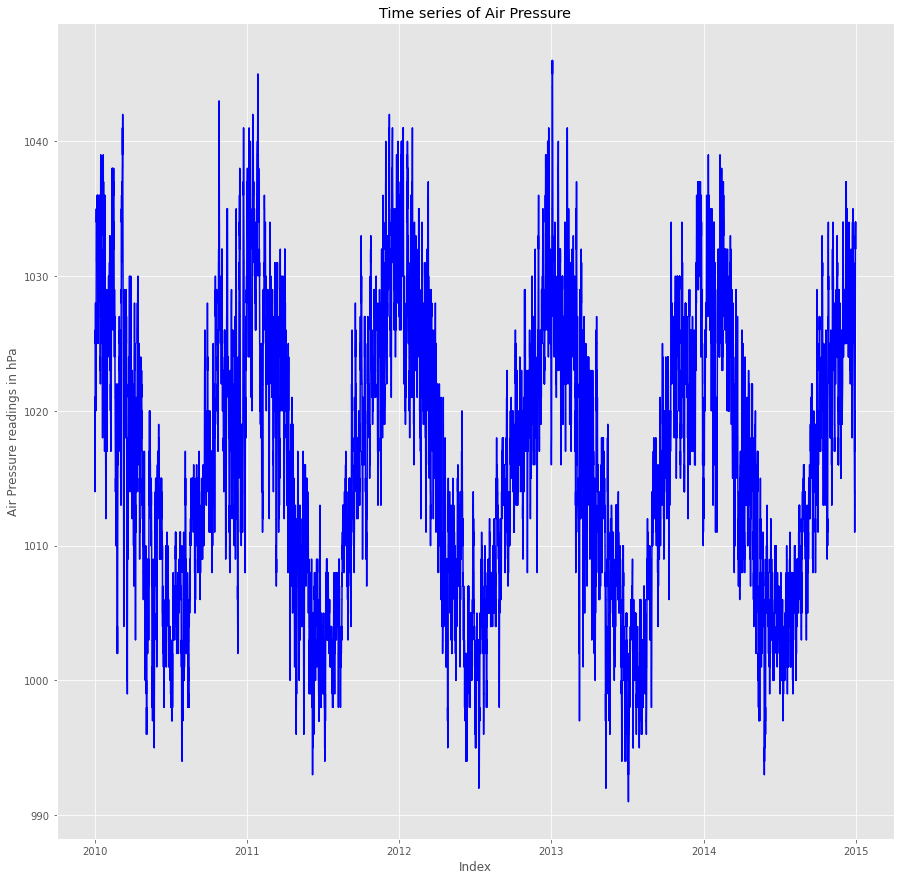

In [7]:
plt.figure(figsize=(15, 15))
plt.plot(df['datetime'],df['PRES'],color='b')
plt.title('Time series of Air Pressure')
plt.xlabel('Index')
plt.ylabel('Air Pressure readings in hPa')

In [8]:
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
train = df.loc[df['datetime'] < split_date]
val = df.loc[df['datetime'] >= split_date]
print(f'Shape of train: {train.shape}')
print(f'Shape of validation: {val.shape}')

Shape of train: (35064, 14)
Shape of validation: (8760, 14)


In [9]:
print(f'size of validation is {np.round((val.shape[0] / df.shape[0])*100,0)}% from whole dataset')

size of validation is 20.0% from whole dataset


# Normalization

In [10]:
mean = train['PRES'].mean()
std = train['PRES'].std()

train_scaled = (train['PRES']-mean)/std
val_scaled = (val['PRES']-mean)/std

In [11]:
#Reset validation set index
val_scaled.reset_index(drop=True, inplace=True)

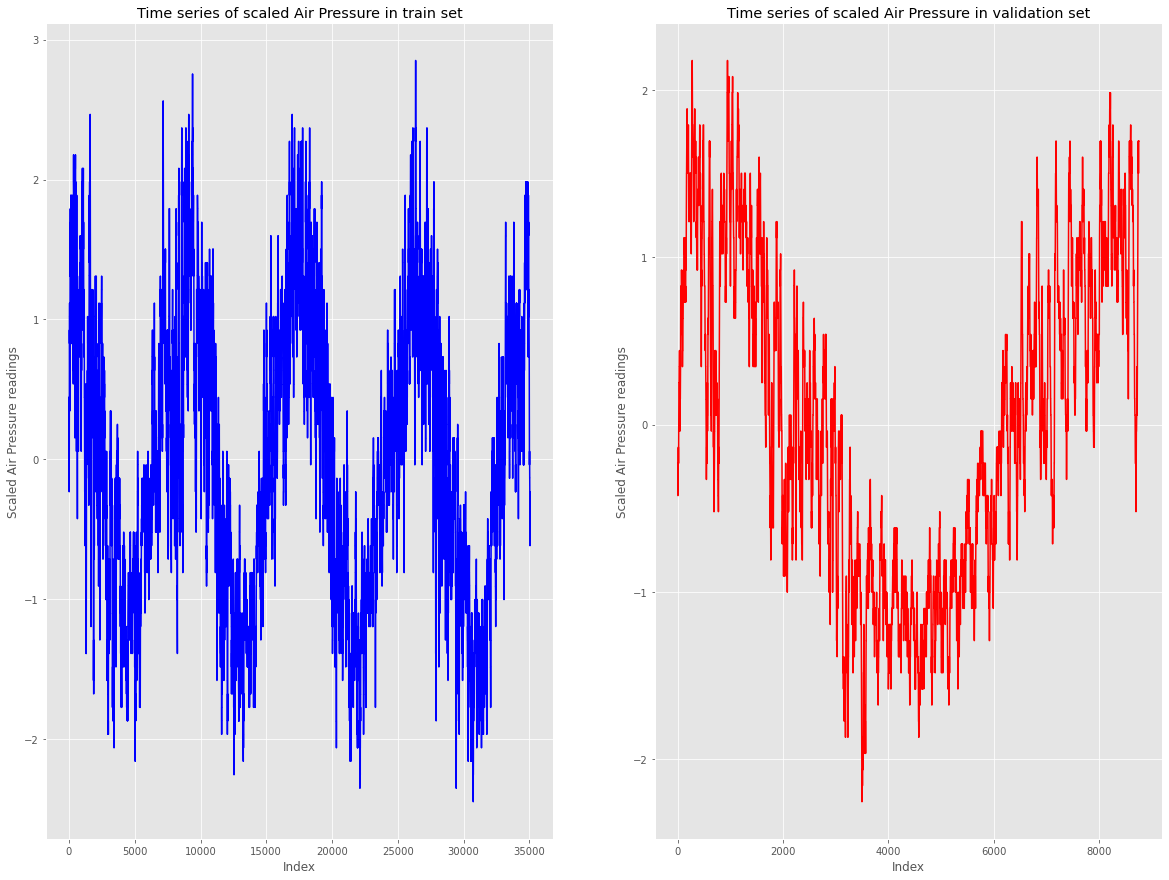

In [12]:
fig,ax=plt.subplots(1,2,figsize=(20, 15))
train_scaled.plot(color='b',ax=ax[0])
ax[0].set_title('Time series of scaled Air Pressure in train set')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Scaled Air Pressure readings')

val_scaled.plot(color='r',ax=ax[1])
ax[1].set_title('Time series of scaled Air Pressure in validation set')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Scaled Air Pressure readings')
plt.show()

# Windowed function

In [13]:
train_scaled_windowed = time_series.windowed_data(train_scaled, window_size=24, 
                                                  batch_size=100, 
                                                  shuffle_buffer=1000)

In [14]:
val_scaled_windowed = time_series.windowed_data(val_scaled, window_size=24, 
                                                  batch_size=100, 
                                                  shuffle_buffer=1000)

# Model

In [17]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
#   tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

## Callback

In [19]:
callback = deep_learning.callback_def('forecasting',metrics="mae")

In [22]:
optimizer = tf.keras.optimizers.Adam(lr=1.0000e-04)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [24]:
history = model.fit(train_scaled_windowed,
                    epochs=50,
                    verbose=2,
                    callbacks=callback, 
                    validation_data=val_scaled_windowed)

Learning rate:  0.001
Epoch 1/50
    347/Unknown - 12s 12ms/step - loss: 0.0389 - mae: 0.1592
Epoch 00001: mae improved from inf to 0.15832, saving model to E:\gitlab\machine-learning\Time_Series\saved_models\forecasting_model.001.h5
351/351 [==============================] - 14s 17ms/step - loss: 0.0385 - mae: 0.1583 - val_loss: 0.0046 - val_mae: 0.0759 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
351/351 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0587
Epoch 00002: mae improved from 0.15832 to 0.05874, saving model to E:\gitlab\machine-learning\Time_Series\saved_models\forecasting_model.002.h5
351/351 [==============================] - 6s 16ms/step - loss: 0.0029 - mae: 0.0587 - val_loss: 0.0025 - val_mae: 0.0554 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
351/351 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0503
Epoch 00003: mae improved from 0.05874 to 0.05027, saving model to E:\gitlab\machine-learning\Time_Series\saved_models\foreca

# plot

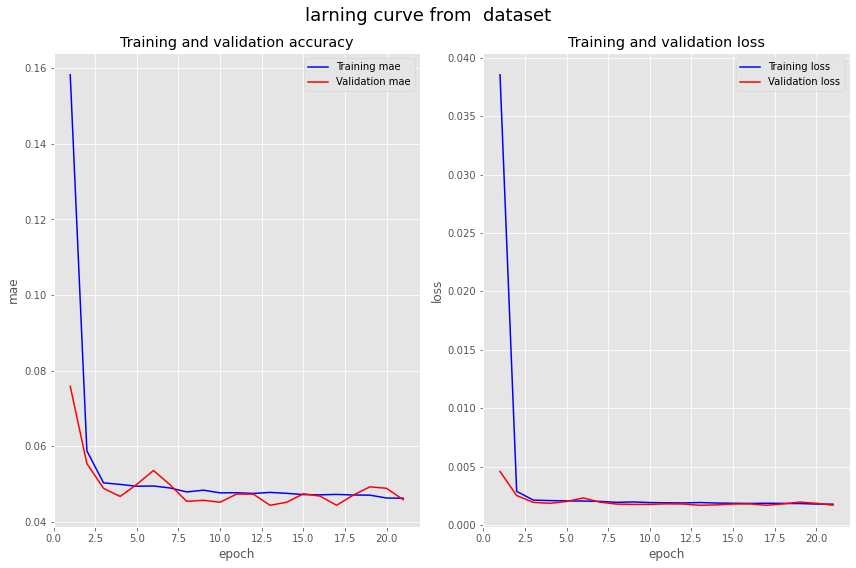

In [25]:
deep_learning.plot_nn(history,params='mae',title='',footnote=None)

## scale data

In [26]:
print(f'mean of training data {np.round(train_scaled.mean(),2)}')
print(f'last average mae from training and validation {0.05} or {5}% from data scale')

mean of training data -0.0
last average mae from training and validation 0.05 or 5% from data scale
